In [295]:
import re
from collections import defaultdict
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import networkx as nx
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

In [296]:

# First, let's open and read the contents of the uploaded file to understand its structure and content.
file_path = 'Suits_1x07.txt'

def read_txt(path):
    with open(path, 'r',encoding='utf-8') as file:
        content = file.read()

    # Displaying the first 500 characters to get a glimpse of the content
    return content

content = read_txt(file_path)
print(content[:400])


Executive Producer: David Bartis Episode %*107

Executive Producer: Doug Liman Production %01007
Executive Producer: Sean Jablonski
Co-Executive Producer: Aaron Korsh
Co-Executive Producer: Jon Cowan
Producer: Gene Klein

Supervising Producer: Kevin Bray
Producer: Steve Wakefield
Director: Tim Matheson

SUITS

"Play the Man"

Episode %*107

Written by

Erica Lipez

Production Draft

Full Blue

Pin


In [297]:
# Extracting dialogues and characters from the script
dialogues = defaultdict(list)
character_pattern = re.compile(r'^([A-Z][A-Z ]+)(?:\s+\(.*\))?$', re.MULTILINE)

# Parsing the script
lines = content.split('\n')
for i, line in enumerate(lines):
    if character_pattern.match(line):
        character = line.strip()
        dialogue = []
        for j in range(i+1, len(lines)):
            dialogue_line = lines[j].strip()
            if dialogue_line == '' or character_pattern.match(dialogue_line):
                break
            dialogue.append(dialogue_line)
        if dialogue:
            dialogues[character].append(' '.join(dialogue))

# Displaying a summary of the dialogues for each character
dialogue_summary = {character: len(dialogues[character]) for character in dialogues}
dialogue_summary




{'SUTTS': 1,
 'LIBRARY': 1,
 'CONFERENCE ROOM': 1,
 'WATER COOLER AREA': 1,
 'OFFICE TOWER OFFICE TOWER': 1,
 'SUITE': 1,
 'MIDTOWN BAR': 1,
 'TEASER': 1,
 'RACHEL': 41,
 'MIKE': 139,
 "MIKE (CONT'D)": 18,
 "RACHEL (CONT'D)": 3,
 'JONES': 12,
 'HARVEY': 97,
 "HARVEY (CONT'D)": 13,
 'DONNA (0.C.)': 1,
 "DONNA (CONT'D)": 4,
 'DONNA': 20,
 'JESSICA': 23,
 "JESSICA (CONT'D)": 10,
 'LOUIS': 8,
 "LOUIS (CONT'D)": 2,
 'KYLE': 45,
 'LOUIS (0.C.)': 1,
 "KYLE (CONT'D)": 2,
 'DANIEL': 5,
 "DANIEL (CONT'D)": 1,
 'SCOTTIE': 50,
 "SCOTTIE (CONT'D)": 2,
 'KYLE MIKE': 1,
 'JESSICA (0.8.)': 1,
 'RACHEL (0.C.)': 1,
 'DONNA (V.O.)': 1,
 'JENNY': 41,
 "JENNY (CONT'D)": 1,
 'DANTEL': 1}

In [298]:
nltk.download('stopwords')

# Function to clean dialogues
def clean_dialogues(dialogues):
    # Preparing a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Pattern to identify and remove non-alphanumeric characters (excluding spaces)
    non_alpha_numeric_pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Pattern to identify and remove dates (simple pattern for common date formats)
    date_pattern = re.compile(r'\b(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{2,4}[-/]\d{1,2}[-/]\d{1,2})\b')

    cleaned_dialogues = defaultdict(list)

    for character, dialogue_list in dialogues.items():
        for dialogue in dialogue_list:
            # Removing non-alphanumeric characters
            dialogue = non_alpha_numeric_pattern.sub('', dialogue)

            # Removing dates
            dialogue = date_pattern.sub('', dialogue)

            # Removing stopwords
            dialogue_words = dialogue.split()
            cleaned_words = [word for word in dialogue_words if word.lower() not in stop_words]
            cleaned_dialogue = ' '.join(cleaned_words)

            cleaned_dialogues[character].append(cleaned_dialogue)

    return cleaned_dialogues

# Cleaning the dialogues
dialogues = clean_dialogues(dialogues)

# Displaying some cleaned dialogues for review
for character, dialogue_list in list(dialogues.items())[:10]:
    print(f"{character}: {dialogue_list[:2]}")



SUTTS: ['107']
LIBRARY: ['KYLE CUBICLE']
CONFERENCE ROOM: ['DONNAS DESK']
WATER COOLER AREA: ['LOUIS OFFICE']
OFFICE TOWER OFFICE TOWER: ['LOBBY JENNYS APARTMENT ELEVATOR VEGAS HOTEL DEBEQUE HOTEL']
SUITE: ['JENNYS APARTMENT HARVEY APARTMENT']
MIDTOWN BAR: ['SUITS 107 Play Man Final Shooting Script 72711']
TEASER: ['1 EXT OFFICE TOWER DAY 1']
RACHEL: ['Watch', 'easier ways kill']
MIKE: ['Imso sorry okay', 'Rachel']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [299]:
# Contando las interacciones entre personajes
interactions = defaultdict(int)

# Limpiamos los nombres de los personajes para unificarlos (eliminando "(CONT'D)" y otros añadidos)
cleaned_dialogues = defaultdict(list)
for character, dialogue in dialogues.items():
    clean_character = character.split(" (")[0]
    cleaned_dialogues[clean_character].extend(dialogue)

# Contando las interacciones
prev_character = None
for line in lines:
    line = line.strip()
    if character_pattern.match(line):
        character = line.split(" (")[0]
        if prev_character and character != prev_character:
            # Contamos la interacción entre prev_character y character
            interaction_pair = tuple(sorted([prev_character, character]))
            interactions[interaction_pair] += 1
        prev_character = character

# Resumen de las interacciones
sorted_interactions = sorted(interactions.items(), key=lambda x: x[1], reverse=True)
sorted_interactions= sorted_interactions[:22]  # Mostrando la  s primeras 10 interacciones más frecuentes

sorted_interactions

[(('HARVEY', 'SCOTTIE'), 98),
 (('MIKE', 'RACHEL'), 69),
 (('JENNY', 'MIKE'), 59),
 (('HARVEY', 'MIKE'), 58),
 (('KYLE', 'MIKE'), 48),
 (('DONNA', 'MIKE'), 23),
 (('JESSICA', 'MIKE'), 22),
 (('JESSICA', 'KYLE'), 17),
 (('HARVEY', 'JONES'), 16),
 (('JENNY', 'KYLE'), 13),
 (('DONNA', 'HARVEY'), 9),
 (('HARVEY', 'LOUIS'), 7),
 (('JENNY', 'RACHEL'), 6),
 (('JESSICA', 'LOUIS'), 5),
 (('DONNA', 'KYLE'), 5),
 (('DANIEL', 'HARVEY'), 5),
 (('KYLE', 'RACHEL'), 4),
 (('LOUIS', 'MIKE'), 3),
 (('KYLE', 'LOUIS'), 3),
 (('DANIEL', 'JONES'), 3),
 (('JONES', 'SCOTTIE'), 3),
 (('HARVEY', 'JENNY'), 3)]

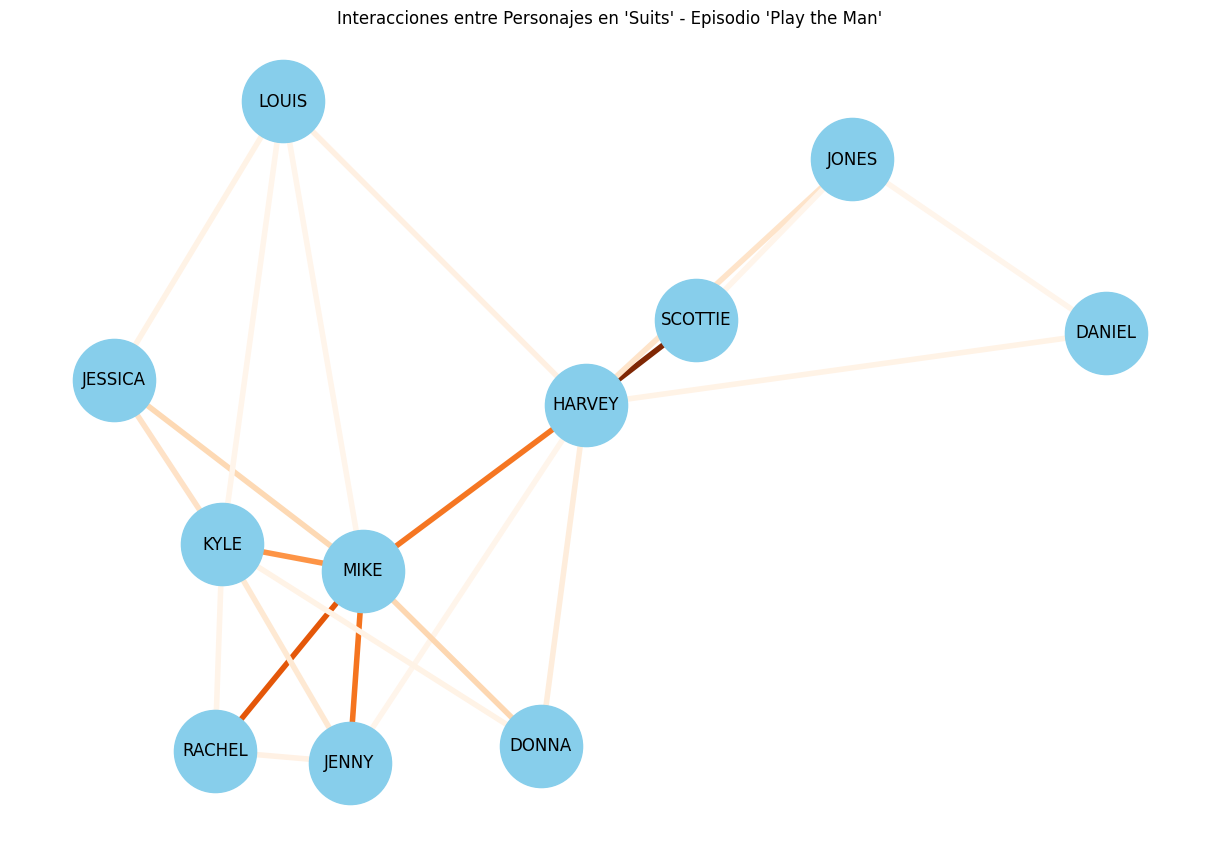

In [300]:
# Creando un grafo a partir de las interacciones
G = nx.Graph()
for (char1, char2), count in sorted_interactions:
    G.add_edge(char1, char2, weight=count)

# Dibujando el grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Para la consistencia del layout
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3500, edge_color=weights, width=4, edge_cmap=plt.cm.Oranges)
plt.title("Interacciones entre Personajes en 'Suits' - Episodio 'Play the Man'")
plt.show()

In [301]:
# Initializing NLTK's Sentiment Intensity Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to get dialogues for a pair of characters
def get_dialogues_for_pair(character1, character2, lines, character_pattern):
    dialogues = []
    current_character = None
    for line in lines:
        if character_pattern.match(line):
            current_character = line.split(" (")[0]
        elif current_character in [character1, character2]:
            dialogues.append(line.strip())
    return dialogues

# Function to analyze sentiment of dialogues
def analyze_sentiment(dialogues):
    sentiment_scores = [sia.polarity_scores(dialogue)["compound"] for dialogue in dialogues if dialogue]
    return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

# Analyzing sentiment for each interaction pair and including the number of interactions
sentiment_summary_with_interactions = {}

for pair, interaction_count in sorted_interactions:
    characters = pair
    dialogues = get_dialogues_for_pair(characters[0], characters[1], lines, character_pattern)
    sentiment_score = analyze_sentiment(dialogues)
    sentiment_summary_with_interactions[characters] = (interaction_count, sentiment_score)

# Displaying the sentiment analysis along with the number of interactions for each pair
for pair, (count, sentiment) in sentiment_summary_with_interactions.items():
    print(f"{pair}: Interactions: {count}, Sentiment Score: {sentiment}")



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luisf\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


('HARVEY', 'SCOTTIE'): Interactions: 98, Sentiment Score: 0.03535837563451776
('MIKE', 'RACHEL'): Interactions: 69, Sentiment Score: 0.027120175438596492
('JENNY', 'MIKE'): Interactions: 59, Sentiment Score: 0.04044046875
('HARVEY', 'MIKE'): Interactions: 58, Sentiment Score: 0.037106137566137565
('KYLE', 'MIKE'): Interactions: 48, Sentiment Score: 0.03040922190201729
('DONNA', 'MIKE'): Interactions: 23, Sentiment Score: 0.039527929373996795
('JESSICA', 'MIKE'): Interactions: 22, Sentiment Score: 0.03794833836858006
('JESSICA', 'KYLE'): Interactions: 17, Sentiment Score: 0.034824358974358975
('HARVEY', 'JONES'): Interactions: 16, Sentiment Score: 0.05029757174392936
('JENNY', 'KYLE'): Interactions: 13, Sentiment Score: 0.04008724137931035
('DONNA', 'HARVEY'): Interactions: 9, Sentiment Score: 0.04643244274809161
('HARVEY', 'LOUIS'): Interactions: 7, Sentiment Score: 0.04891161290322581
('JENNY', 'RACHEL'): Interactions: 6, Sentiment Score: 0.03239821428571429
('JESSICA', 'LOUIS'): Inte

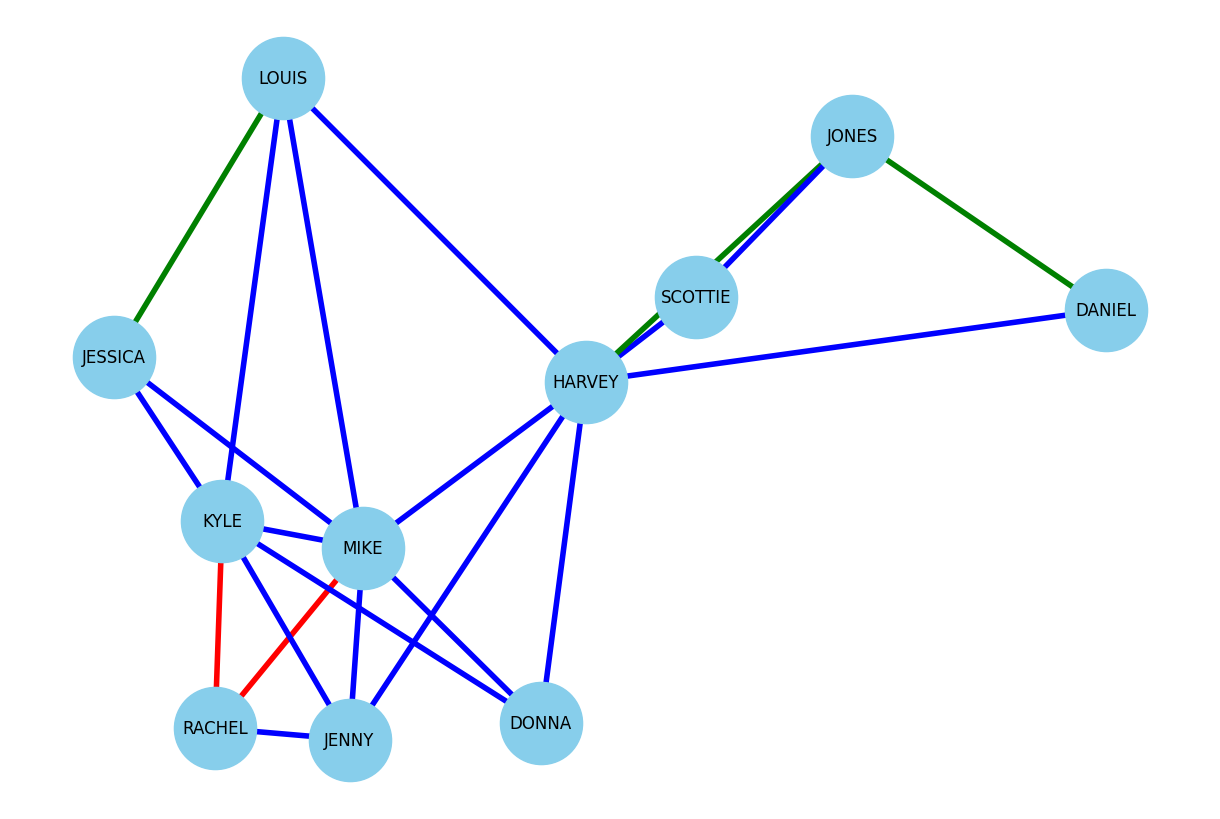

In [302]:
# Creando el grafo
G = nx.Graph()

# Añadiendo los nodos y aristas basados en las interacciones y análisis de sentimientos
for (character1, character2), (interaction_count, sentiment_score) in sentiment_summary_with_interactions.items():
    G.add_edge(character1, character2, weight=interaction_count)

    # Determinando el color de la arista basado en la puntuación de sentimiento
    if sentiment_score > 0.05:  # Suponiendo que un score > 0.05 es positivo
        color = 'green'
    elif sentiment_score < 0.03:  # Suponiendo que un score < -0.05 es negativo
        color = 'red'
    else:
        color = 'blue'  # Sentimientos neutrales o cercanos a cero

    # Asignando el color a la arista
    G[character1][character2]['color'] = color

# Dibujando el grafo
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, edge_color=colors, width=4, node_size=3500, node_color='skyblue')
plt.show()


In [303]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string

# Asegúrate de tener descargados stopwords y wordnet
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocesamiento del texto
def preprocess_text(text):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    text = "".join([ch for ch in text if ch not in exclude])
    text = " ".join([lemma.lemmatize(word) for word in text.lower().split() if word not in stop])
    return text

# Preprocesar los diálogos
processed_dialogues = {character: [preprocess_text(dialogue) for dialogue in dialogues] for character, dialogues in cleaned_dialogues.items()}

# Crear un modelo LDA para cada personaje
for character, dialogues in processed_dialogues.items():
    if dialogues:
        # Vectorización TF-IDF
        tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
        tfidf_matrix = tfidf.fit_transform(dialogues)

        # Creando un corpus para LDA
        corpus = corpora.Sparse2Corpus(tfidf_matrix, documents_columns=False)
        id_map = dict((v, k) for k, v in tfidf.vocabulary_.items())

        # Modelo LDA
        lda = models.LdaModel(corpus=corpus, id2word=id_map, num_topics=5, passes=10)
        
        # Mostrar los tópicos
        print(f"Tópicos para {character}:")
        for topic in lda.print_topics(num_words=5):
            print(topic)
        print("\n")


ModuleNotFoundError: No module named 'gensim'